In [57]:
import sys
import numpy as np
import torch
import learn2learn as l2l
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms

from PIL.Image import LANCZOS
from csv import writer

from PIL import Image
import pandas as pd
import cv2
import plotly.express as px
import matplotlib.pyplot as plt
#torch.cuda.is_available()

In [2]:
sys.path.append('/home/anuj/Desktop/Work/TU_Delft/research/implement/learning_to_meta-learn')
sys.path

['/home/anuj/Desktop/Work/TU_Delft/research/implement/learning_to_meta-learn/src',
 '/home/anuj/.vscode/extensions/ms-toolsai.jupyter-2022.6.1201981810/pythonFiles',
 '/home/anuj/.vscode/extensions/ms-toolsai.jupyter-2022.6.1201981810/pythonFiles/lib/python',
 '/home/anuj/anaconda3/envs/torch/lib/python39.zip',
 '/home/anuj/anaconda3/envs/torch/lib/python3.9',
 '/home/anuj/anaconda3/envs/torch/lib/python3.9/lib-dynload',
 '',
 '/home/anuj/anaconda3/envs/torch/lib/python3.9/site-packages',
 '/home/anuj/anaconda3/envs/torch/lib/python3.9/site-packages/IPython/extensions',
 '/home/anuj/.ipython',
 '/home/anuj/Desktop/Work/TU_Delft/research/implement/learning_to_meta-learn']

In [3]:
# from data.taskers import gen_tasks
from src.zoo.archs import CCVAE
from src.zoo.trident_utils import setup, inner_adapt_trident, loss, accuracy
# from data.loaders import CUBirds200
from src.zoo.trident_utils import inner_adapt_trident, setup
from data.taskers import gen_tasks


In [4]:
reconst_loss = nn.MSELoss(reduction='none')

class Args:
    def __init__(self, wt_ce, klwt, rec_wt, beta_l, beta_s):
        #args.wt_ce, args.klwt, args.rec_wt, args.beta_l, args.beta_s
        self.wt_ce = wt_ce
        self.klwt = klwt
        self.rec_wt = rec_wt
        self.beta_l = beta_l
        self.beta_s = beta_s
        self.dataset = 'miniimagenet'
        self.root = '../../dataset/mini_imagenet'
        self.task_adapt = True
        self.task_adapt_fn = 'tafe'
        self.n_ways = 5
        self.k_shots = 5
        self.q_shots = 10
        self.zl = 64
        self.zs = 64
        self.reconstr = 'std'
        self.device = 'cpu'
        self.wn_channels = 32
        self.wm_channels = 64
        self.order = False
        self.inner_lr = 0.001
        self.meta_lr = 0.0001
        self.adapt_steps = 5
        self.meta_batch_size = 20
        self.download = False
        self.log_data = False


args = Args(100, False, 0.01, 1, 1)

In [5]:
learner = torch.load(
    '/home/anuj/Desktop/Work/TU_Delft/research/implement/learning_to_meta-learn/logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/model_33000.pt', map_location=args.device)
learner = learner.to(args.device)

In [6]:
test_tasks = gen_tasks(args.dataset, args.root, download=args.download, mode='test',
                               n_ways=args.n_ways, k_shots=args.k_shots, q_shots=args.q_shots, num_tasks=600)

In [7]:
task = test_tasks.sample()
evaluation_loss, evaluation_accuracy, learner, queries, labels = inner_adapt_trident(task, reconst_loss, learner, args.n_ways, args.k_shots, args.q_shots, args.adapt_steps, args.device, args.log_data, args, extra="No")

/home/anuj/anaconda3/envs/torch/lib/python3.9/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/build/aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [8]:
attfex = learner.module.classifier_vae.encoder
G = attfex.forward(task[0], 'outer')
G = G.reshape(G.shape[0], -1, 5, 5)

In [9]:
G.shape

torch.Size([50, 32, 5, 5])

# Activation Heatmap

In [10]:
#using the approach in https://arxiv.org/abs/1612.03928
output = np.abs(G.detach().numpy()[0])
output = np.sum(output, axis = 0).squeeze()
output.shape

(5, 5)

In [11]:
#resize and convert to image 
output = cv2.resize(output, (84, 84))
output.shape

(84, 84)

In [66]:
cv2.imwrite('./features.jpg', output)

True

In [12]:
output /= output.max()
output *= 255
255 - output.astype('uint8')

array([[191, 191, 191, ..., 193, 193, 193],
       [191, 191, 191, ..., 193, 193, 193],
       [191, 191, 191, ..., 193, 193, 193],
       ...,
       [180, 180, 180, ..., 198, 198, 198],
       [180, 180, 180, ..., 198, 198, 198],
       [180, 180, 180, ..., 198, 198, 198]], dtype=uint8)

In [13]:
output.shape

(84, 84)

In [22]:
queries[0].detach().numpy()

array([[[0.99607843, 0.9764706 , 0.972549  , ..., 0.99607843,
         1.        , 0.99215686],
        [0.9843137 , 0.5647059 , 0.34901962, ..., 0.9647059 ,
         0.827451  , 0.7137255 ],
        [0.32941177, 0.2901961 , 0.3254902 , ..., 0.23921569,
         0.2901961 , 0.25882354],
        ...,
        [0.23529412, 0.21176471, 0.22745098, ..., 0.30980393,
         0.36078432, 0.36078432],
        [0.20784314, 0.23137255, 0.25490198, ..., 0.3647059 ,
         0.3529412 , 0.37254903],
        [0.21176471, 0.22352941, 0.21960784, ..., 0.38431373,
         0.3764706 , 0.37254903]],

       [[0.9882353 , 0.9764706 , 0.9764706 , ..., 0.6156863 ,
         0.8862745 , 0.6156863 ],
        [0.9843137 , 0.5647059 , 0.35686275, ..., 0.7058824 ,
         0.72156864, 0.4627451 ],
        [0.34117648, 0.3019608 , 0.33333334, ..., 0.2509804 ,
         0.2509804 , 0.2627451 ],
        ...,
        [0.2       , 0.16078432, 0.20784314, ..., 0.19607843,
         0.2509804 , 0.27058825],
        [0.1

In [42]:
labels

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1])

In [45]:
queries.permute(0,2,3,1).shape

torch.Size([50, 84, 84, 3])

In [58]:
processed = []
for feature_map in G:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)


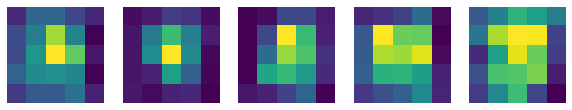

In [64]:
fig = plt.figure(figsize=(10, 20))
for i in range(len(processed[1::10])):
    a = fig.add_subplot(1, 5, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    #a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
#generate heat maps 
heatmap = cv2.applyColorMap(output, cv2.COLORMAP_JET)
heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)

In [62]:
fig1 = px.imshow(np.array(queries.permute(0,2,3,1))[1::10], facet_col=0 ,facet_col_wrap=5)
fig1.show()

In [28]:
cv2.imwrite('query0.png', (queries[0].detach().numpy()*255).reshape(queries.shape[2], queries.shape[3], queries.shape[1])[::-1])

True

Extremely small (5x5) feature maps. Too small for any reasonable activation visualization, w or w/o upsampling. 

# GradCAM